Introduction to object-Oriented Programming in Python
---

Fundamentally, the idea of object-oriented programming is to be able to define functions and procedures that apply to specific objects.
Think for example about multiplication operator: it has two completely different meanings whether it applies to real number or to matrices. 
The idea of OOP it to bundle together all such procedures for each single object within a so-called Class. 
Data stored within are called attributes, and the functions are methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A first quick overview of a class

We create here an Option class, which contains, as attributes, all the contractually-defined elements of a European Call or Put option price.

In [2]:
class Option(object):
    def __init__(self, CP, S0, t0, r, K, T): 
        ## this function is called the constructor and is automatically run when instantiating the class
        
        self.CP = CP ## True for a Call, False for a Put
        self.S0 = S0   ## Initial value of the stock price
        self.t = t0   ## Initial time
        self.r = r   ## instantaneous risk-free rate
        self.K  = K  ## Strike
        self.T = T   ## Maturity (>t0)
        
    def __repr__(self):
        ## This is the representation function, essentially a "help" description of the class
        if self.CP:
            if self.S0>self.K: 
                msg = "Call option in the money"
            elif self.S0<self.K:
                msg = "Call option out of the money"
            else:
                msg = "Call option at the money"
        else:
            if self.S0>vK: 
                msg = "Call option out of the money"
            elif self.S0<self.K:
                msg = "Call option in the money"
            else:
                msg = "Call option at the money"
        return msg

We now create an instance of this option class as

In [3]:
S0, t0, r, K, T = 100., 0., 0., 90., 1.
myOpt = Option(True, S0, t0, r, K, T)

In [4]:
print(type(myOpt))
print(myOpt.T)
print(myOpt)

<class '__main__.Option'>
1.0
Call option in the money


# The full option pricing class

In [5]:
from scipy.stats import norm

Recall the Black-Scholes model and the formula to price European Call and Put options within. We can further define the Vega as the derivative of the Call/Put price with respect to the volatility parameter $\sigma$.
It admits the closed-form representation:
$$
\textrm{Vega} = S_t \mathcal{N}'(d_+)\sqrt{T-t}.
$$

In [8]:
class callOptionBs(object):
    ''' European call option in the Black-Scholes model.
        CP:     ## True for a Call, False for a Put
        S0:     ## Initial value of the stock price
        t0:     ## Initial time
        r:      ## instantaneous risk-free rate
        K:      ## Strike
        T:      ## Maturity (>t)
        sigma:  ## volatility parameter
Methods
=======
price : float, returns the price of the option in the Black-Scholes model
impVol: float. returns the implied volatility given an option price
'''

    def __init__(self, CP, S0, t0, r, K, T, sigma):
        self.CP = CP
        self.S0 = S0
        self.t0 = t0
        self.r = r
        self.K  = K
        self.T = T
        self.sigma = sigma
        
    def price(self):
        tau = self.T-self.t0
        sigmtau = self.sigma*np.sqrt(self.T)
        k = np.log(self.K/self.S0)  - self.r*tau
        dp = -k/sigmtau + 0.5*sigmtau
        dm = dp - sigmtau
        if self.CP: 
            return self.S0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))
        else: 
            return self.S0*(np.exp(k)*norm.cdf(-dm) - norm.cdf(-dp))
    
    def vega(self): ## returns the Vega of the option, i.e. its derivative with respect to the volatility parameter sigma
        tau = self.T-self.t0
        sigmtau = self.sigma*np.sqrt(self.T)
        k = np.log(self.K/self.S0)  - self.r*tau
        dp = -k/sigmtau + 0.5*sigmtau
        dm = dp - sigmtau
        return self.S0 * norm.cdf(dp, 0., 1.) * np.sqrt(tau)

    def impVol(self, obsPrice, sigma0=0.2, nbIter=100):
        option = callOptionBs(self.CP, self.S0, self.t0, self.r, self.K, self.T, sigma0)
        for _ in range(nbIter):
            option.sigma -= (option.price() - obsPrice) / option.vega()
        return option.sigma

In [9]:
CP, S0, t0, K, T, r, sigma = True, 100., 0., 105., 1.0, 0.05, 0.2
option = callOptionBs(CP, S0, t0, r, K, T, sigma)
print(type(option))
print(option.price())
print(option.vega())
print(option.impVol(option.price()))
print(option.impVol(obsPrice=7.))

<class '__main__.callOptionBs'>
8.02135223514317
54.22283335848053
0.2
0.17426990587356414


## Plotting the class

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
%matplotlib inline

In [11]:
T = np.linspace(0.1, 2., 20)
K = np.linspace(80., 120., 21)
KK, TT = np.meshgrid(K, T)
prices = np.zeros((len(T), len(K)))
vegas = np.zeros((len(T), len(K)))
for t in enumerate(T):
    #print "--------------------------"
    for k in enumerate(K):
        #print t, k
        option.T = t[1]
        option.K = k[1]
        prices[t[0], k[0]] = option.price()
        vegas[t[0], k[0]] = option.vega()

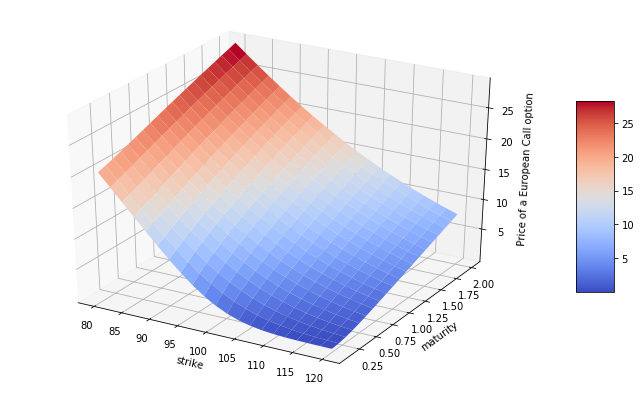

In [17]:
fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(KK, TT, prices, rstride=1, cstride=1,cmap=cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel('Price of a European Call option')
fig.colorbar(surf, shrink=0.5, aspect=5);

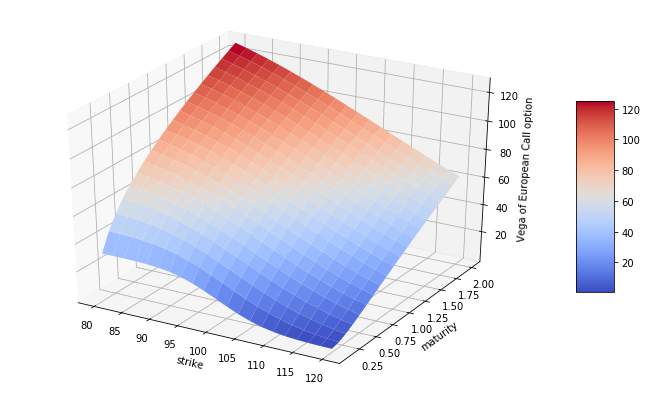

In [18]:
fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(KK, TT, vegas, rstride=1, cstride=1,
cmap=cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel('Vega of European Call option')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()